In [1]:
!pip install transformers==3.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.0/769.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 34.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [2]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
!git clone https://github.com/ChaymaeJhabli/FederatedLearning.git

Mounted at /content/drive


In [5]:
df = pd.read_csv('./FederatedLearning/data/dep1_sentiment_tweets3.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,just had a real good moment. i missssssssss hi...,0
1,1,is reading manga http://plurk.com/p/mzp1e,0
2,2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,3,@lapcat Need to send 'em to my accountant tomo...,0
4,4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [6]:
import pandas as pd

df = pd.DataFrame(df)
#Shuffling the DataFrame prevents the model from learning any patterns or biases based on the inherent order of the data
# Shuffle the DataFrame
df = df.sample(frac=1.0, replace=False)

# Afficher les 20 premières lignes
print(df.head(20))

       Unnamed: 0                                              tweet  target
4228         4228                 http://twitpic.com/6ed7j - Oh yes        0
10699       10699  nothing happened to make me sad but i almost b...       1
4466         4466  @JudgeJadams Good (that' you'll be there, not ...       0
5220         5220  Ok I REALLY need to go to bed and stop playing...       0
6097         6097  @joemqi j.e.a.l.o.u.s. what new stuff are you ...       0
1741         1741  The Poken are clearly conspiring against me  H...       0
10202       10202  Gene Simmons, Ph.D. offers mental wellbeing to...       0
2409         2409  @JosephTheGreat dont see why not mate but its ...       0
4280         4280         @AdorkableMellie I love that! What kind??        0
6497         6497              Bun venit @cursuriafaceri pe Twitter        0
8759         8759  Does anyone else feel really weird at night ti...       0
299           299                             What a lovely night.         0

##Partitioning

###IID

In [9]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [10]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """

  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)

  return client_dict

# MAIN

## MODELS

In [11]:
#Base Roberta model
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [12]:
model = RobertaClass()
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [13]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [14]:
class TweetData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def get_labels(self):
      l = []
      for i in range(len(self.data)):
        # text = str(self.text[i])
        # text = " ".join(text.split())

        # inputs = self.tokenizer.encode_plus(
        #     text,
        #     None,
        #     add_special_tokens=True,
        #     max_length=self.max_len,
        #     pad_to_max_length=True,
        #     return_token_type_ids=True
        # )

        l.append(self.targets[i])

      return l


    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [15]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.text = dataset.tweet
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.targets = self.data.target

  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      text = str(self.text[index])
      text = " ".join(text.split())

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      token_type_ids = inputs["token_type_ids"]


      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.float)
      }

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []

    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      model.train()

      for _,data in enumerate(self.train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = self.model(ids, mask, token_type_ids)
        loss = self.loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += self.calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        self.optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        self.optimizer.step()

      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      print("-------------------------------")
      epochloss.append(epoch_loss)
      epochacc.append(epoch_accu)

    return model.state_dict(), epochacc[-1], epochloss[-1]

In [16]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []

  optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)

  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)

    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")

  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))

  return model

In [17]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = TweetData(train_dataset, tokenizer, MAX_LEN)
testing_set = TweetData(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (13513, 3)
TRAIN Dataset: (10810, 3)
TEST Dataset: (2703, 3)


In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.6686993837356567
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 1: 77.42830712303423
Training Loss Epoch: 0.6403328721575877
Training Accuracy Epoch: 77.42830712303423
-------------------------------
Training Loss per 5000 steps: 0.2192019820213318
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 1: 93.43200740055504
Training Loss Epoch: 0.19690233777167604
Training Accuracy Epoch: 93.43200740055504
-------------------------------
Training Loss per 5000 steps: 0.6022320985794067
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 1: 97.3172987974098
Training Loss Epoch: 0.09257986729019596
Training Accuracy Epoch: 97.3172987974098
-------------------------------
Round: 1... 	Average Loss: 0.31
Round: 1... 	Average Accuracy: 89.393
Training Loss per 5000 steps: 0.18190903961658478
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 1: 96.11470860314523
Training Loss Epoch: 0.1271574188

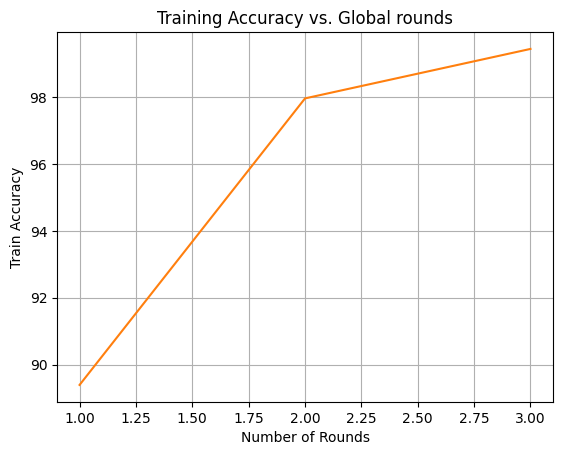

In [19]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [20]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [21]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [22]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_iid_trained, testing_loader, loss_function) #dep1_sentiment_tweets3.csv
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


4it [00:00, 33.96it/s]

Validation Loss per 100 steps: 0.0010793874971568584
Validation Accuracy per 100 steps: 100.0


1352it [00:43, 30.84it/s]

Validation Loss Epoch: 0.30290209146484476
Validation Accuracy Epoch: 93.08176100628931
Accuracy on test data = 93.08%


Training Loss per 5000 steps: 0.0032945789862424135
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.003496901767973143
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 0.0044408333487808704
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.002012252055395108
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 0.0017924022395163774
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.0012434781663334714
Training Accuracy Epoch: 100.0
-------------------------------
Round: 1... 	Average Loss: 0.002
Round: 1... 	Average Accuracy: 100.0
Training Loss per 5000 steps: 0.0024093398824334145
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.001168385456996755
Training Accuracy Epoch: 100.0
---------------------

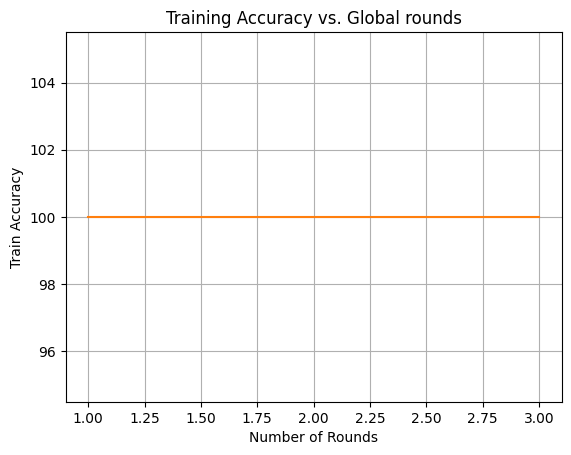

In [28]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_non_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [29]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_non_iid_trained, testing_loader, loss_function) #dep1_sentiment_tweets3.csv
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


4it [00:00, 32.87it/s]

Validation Loss per 100 steps: 0.0007163104601204395
Validation Accuracy per 100 steps: 100.0


1352it [00:44, 30.69it/s]

Validation Loss Epoch: 0.7486053372602586
Validation Accuracy Epoch: 90.71402145763966
Accuracy on test data = 90.71%
